In [ ]:
 %matplotlib inline


# Regresión Logística

Sobre el dataset definido se toma el 20% de los ejemplos para prueba, y se muestran los efectos de la variación del parámetro de regularización C. 
Al aplicar escalado (minmax) mejoró levemente el Score. 
De este dataset se excluyeron los datos categóricos.


Automatically created module for IPython interactive environment
Calculando ...
[3]
C=0.000 Test_Score=0.711 Mean_CV_Score=0.743
[5]
C=0.001 Test_Score=0.807 Mean_CV_Score=0.804
[4]
C=0.010 Test_Score=0.859 Mean_CV_Score=0.850
[4]
C=0.100 Test_Score=0.867 Mean_CV_Score=0.852
[6]
C=1.000 Test_Score=0.874 Mean_CV_Score=0.852
[7]
C=10.000 Test_Score=0.867 Mean_CV_Score=0.852
[6]
C=100.000 Test_Score=0.867 Mean_CV_Score=0.854
[7]
C=1000.000 Test_Score=0.867 Mean_CV_Score=0.854
[7]
C=10000.000 Test_Score=0.867 Mean_CV_Score=0.854
[7]
C=100000.000 Test_Score=0.867 Mean_CV_Score=0.854
Tardó 0.179s
             C  Ordenada      Sexo   EdadIng    AñoIng    EscSec   Pública   Técnica    Ciudad     C1lib     C1reg    C1prom     C2lib     C2reg    C2prom
0       0.0001 -0.003431 -0.000493 -0.000545 -0.002197 -0.002366 -0.001747 -0.001678 -0.002018  0.003382 -0.003408 -0.003228  0.005995 -0.001755 -0.003487
1       0.0010 -0.029939 -0.004479 -0.004472 -0.019522 -0.021341 -0.014129 -0.015217 -0.0170

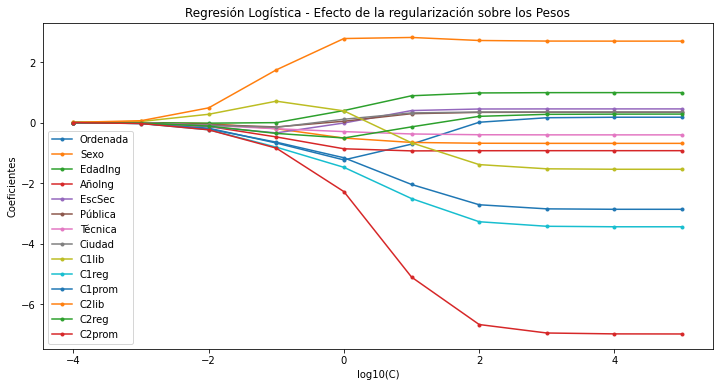

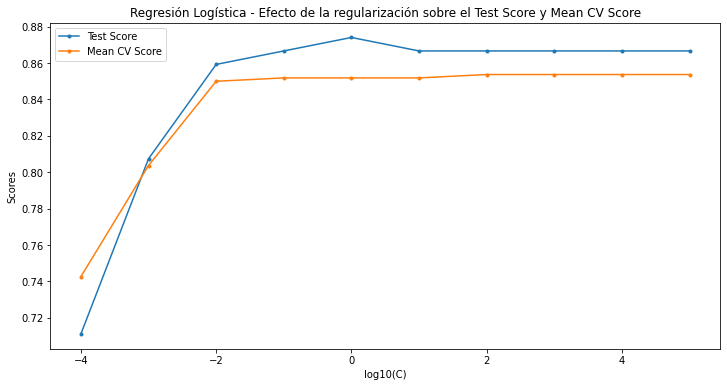

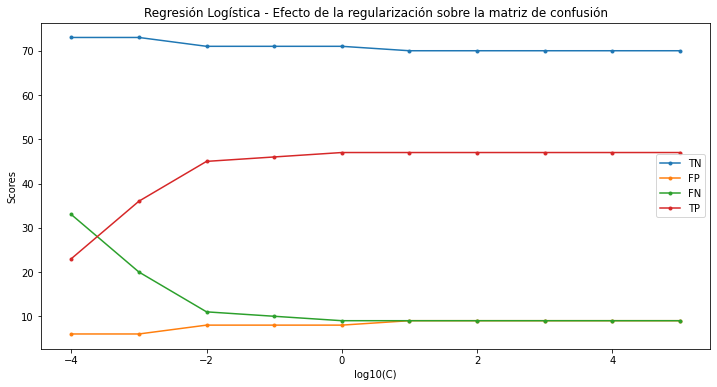

In [22]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from time import time
from numpy import genfromtxt
from sklearn import linear_model
from sklearn import preprocessing
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.svm import l1_min_c
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_openml

#'Sexo',	'EdadIng',	'AñoIng',	'Pública',	'Técnica',	'C1lib',	'C1reg',	'C1prom',	'C2lib',	'C2reg',	'C2prom', 'Abandona?'
#Columnas 0 a 13 (excluyendo 3 y 6), características y resultado esperado
ds_floats = genfromtxt('dataset-sinnulos-completo.csv', dtype=float, delimiter=';', usecols = (0,1,2,4,5,7,8,9,10,11,12,13), skip_header=True,encoding='latin-1')

#'NomEscSec',	'CiudadAlu'
#Columnas 3 y 6, características categóricas
ds_strs = genfromtxt('dataset-sinnulos-completo.csv', dtype=str,  delimiter=';', usecols = (3,6),  skip_header=True, encoding='latin-1')

#se codifican las características categóricas (OneHotEncoder no tuvo buena performance)
enc = preprocessing.OrdinalEncoder()
X_cat = enc.fit_transform(ds_strs)

#enc = preprocessing.OneHotEncoder()
#X_esc_y_ciudad = enc.fit_transform(ds_strs).toarray()
#print(enc.get_feature_names())

#se toman las primeras 10 columnas numéricas
X_num = ds_floats[:,:11]
#se toman las predicciones
y = ds_floats[:,11]
#se agregan las dos columnas categoricas
X = np.c_[X_num[:,0:3], X_cat[:,0], X_num[:,[3,4]], X_cat[:,1], X_num[:,5:]] 
           
np.set_printoptions(precision=4, suppress=True, linewidth=1000)

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
#print(X_scaled[:11,:]) #muestra primeras 10 filas

#particiona el dataset, reservando el 20% para prueba 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

print("Calculando ...")
start = time()

# l1_min_c, obtiene el valor min de C para l1 con liblinear, l1_min_c(X_train, y_train, loss='log') 
# tal que al menos un coef sea mayor que cero.
# np.logspace(2, 6, 15) genera 15 números que van de 1e0 a 1e6 
cs =  np.logspace(-4, 5, 10, base=10)
clf = linear_model.LogisticRegression(penalty='l2', max_iter=10000, solver='liblinear')

coefs_ = []
test_scores = []
meancv_scores = []
cms = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X_train, y_train)
    print(clf.n_iter_)
    test_score = clf.score(X_test, y_test)
    y_pred=clf.predict(X_test)
    cm = confusion_matrix(y_test,y_pred).ravel().reshape(1,-1)
    coefint=np.r_[clf.intercept_.copy(), clf.coef_.ravel().copy()]    
    coefs_.append(coefint)
    test_scores.append(test_score)
    cms.append(cm[0,:])
    meancv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    meancv_scores.append(meancv_score)
    print("C=%0.3f Test_Score=%0.3f Mean_CV_Score=%0.3f" %(c,test_score,meancv_score))
    
print("Tardó %0.3fs" % (time() - start))

resultados=np.c_[cs,coefs_]
nombres=['C', 'Ordenada', 'Sexo',	'EdadIng',	'AñoIng',	'EscSec', 'Pública',	'Técnica', 'Ciudad',	'C1lib',	'C1reg',	'C1prom',	'C2lib',	'C2reg',	'C2prom'] 

rs=pd.DataFrame(data=resultados,columns=nombres)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(rs) 

#('Sexo',	'EdadIng',	'AñoIng',	'Pública',	'Técnica',	'C1lib',	'C1reg',	'C1prom',	'C2lib',	'C2reg',	'C2prom', 'EscSec', 'Ciudad','Ordenada')
coefs_ = np.array(coefs_)
plt.figure(1,figsize=(12,6))
plt.plot(np.log10(cs), coefs_, marker='.')
ymin, ymax = plt.ylim()
plt.xlabel('log10(C)')
plt.ylabel('Coeficientes')
plt.title('Regresión Logística - Efecto de la regularización sobre los Pesos')
plt.axis('tight')
plt.legend(nombres[1:], loc="best", fontsize='medium')
plt.show()
print(" ")

scores=np.c_[test_scores,meancv_scores]
plt.figure(2,figsize=(12,6))
plt.plot(np.log10(cs), scores, marker='.')
ymin, ymax = plt.ylim()
plt.xlabel('log10(C)')
plt.ylabel('Scores')
plt.title('Regresión Logística - Efecto de la regularización sobre el Test Score y Mean CV Score')
plt.axis('tight')
plt.legend(('Test Score',	'Mean CV Score'), loc="best", fontsize='medium')
plt.show()
print(" ")

cms = np.array(cms)
plt.figure(3,figsize=(12,6))
plt.plot(np.log10(cs), cms, marker='.')
ymin, ymax = plt.ylim()
plt.xlabel('log10(C)')
plt.ylabel('Scores')
plt.title('Regresión Logística - Efecto de la regularización sobre la matriz de confusión')
plt.axis('tight')
plt.legend(('TN',	'FP',	'FN',	'TP'), loc="best", fontsize='medium')
plt.show()

rs.to_excel("resultados.xlsx")  
#np.savetxt('resultados.csv', resultados, delimiter=';', header='C;Sexo;EdadIng;AñoIng;Pública;Técnica;C1lib;C1reg;C1prom;C2lib;C2reg;C2prom;EscSec;Ciudad;Ordenada')
